Run cells by pressing STRG + ENTER or SHIFT + ENTER to run a cell and proceed to the next one

# Python implementation of CIB/XTalk Code


 Import required packages:


In [461]:
# packages
import numpy as np
import csv
import time
import sys
%matplotlib notebook
import matplotlib.pyplot as plt
#from scipy.stats import gaussian_kde
from scipy import linalg as linalg
from scipy import stats

Define functions:

In [462]:
# The Functions as in Matlab

# Channel Imbalance
# this is the old definition and without correlation, 
# to be updated by one of the versions Shaun mentioned
def ranCI(sigma_ci_re,sigma_ci_im, noCI):
    ci = np.random.randn(2,noCI)*sigma_ci_re + 1j*np.random.randn(2,noCI)*sigma_ci_im
    return ci

# test ranCI where Transmit and Receive are perfectly correlated in real and imag
# indeed the result is worse (more spread) 
def ranCI2(sigma_ci_re, sigma_ci_im, noCI):
    cit = np.random.randn(noCI)*sigma_ci_re + 1j*np.random.randn(noCI)*sigma_ci_im
    cir = cit
    ci = np.stack((cit,cir))
    return ci

# test ranCI where T and R are perfectly correlated in magnitude but real and imag are random in transmit and equal (magn/sqrt(2)) in receive
# this yields a total different distribution in the outcome biomass errors with wider spread, almost no negative errors (when looking not an abs)
# but also a higher concentration on the low errors
# conclusion --> it does make a difference which CI model to use
def ranCI3(sigma_ci_re, sigma_ci_im, noCI):
    cit = np.random.randn(noCI)*sigma_ci_re + 1j*np.random.randn(noCI)*sigma_ci_im
    cir = np.zeros((noCI),dtype = "complex")
    for idx,elem in enumerate(cit):
        cir[idx] = abs(elem)/np.sqrt(2) + 1j*abs(elem)/np.sqrt(2)
    ci = np.stack((cit,cir))
    return ci

# another CIB scenario with the updated distribution info for T and R but no correlation
# this yields results close to ranCI, probably because there is no correlation
def ranCI4(sigma_ci_re_t, sigma_ci_im_t, sigma_ci_re_r, sigma_ci_im_r, noCI):
    cit = np.random.randn(noCI)*sigma_ci_re_t + 1j*np.random.randn(noCI)*sigma_ci_im_t
    cir = np.random.randn(noCI)*sigma_ci_re_r + 1j*np.random.randn(noCI)*sigma_ci_im_r
    ci = np.stack((cit,cir))
    return ci

# a further CIB scenario with different distributions for transmit and receive and a correlation of 
# the real part (real_corr) which leads to a lesser correlation of the magnitudes, while the phases (angles)
# remain uncorrelated
# However this also correlates the real part -> valid?
# this yields wider spread (higher mean and std of biomass errors) but also a nice distribution shape
def ranCI5(sigma_ci_re_t, sigma_ci_im_t, sigma_ci_re_r, sigma_ci_im_r, real_corr, noCI):
    # define covariance matrix 
    cov = np.array([[sigma_ci_re_t**2, 0, real_corr*sigma_ci_re_t*sigma_ci_re_r, 0],
                    [0               , sigma_ci_im_t**2, 0                    , 0],
                    [real_corr*sigma_ci_re_r*sigma_ci_re_t,0, sigma_ci_re_r**2, 0],
                    [0               ,                     0, 0, sigma_ci_im_r**2]])
    # define means 
    means = [0,0,0,0]
    # draw samples from multivariate normal distribution
    samples = np.random.multivariate_normal(means, cov, size = noCI)
    samples = samples.T
    # transform into complex transmit and receive samples
    transmit = samples[0] + 1j*samples[1]
    receive  = samples[2] + 1j*samples[3]
    ci = np.stack((transmit,receive))
    return ci
    
# xTalk
def ranXT(mag_xt_dB,sigma_xt_dB,xtCov,noCI):
    xt_dB = np.random.randn(noCI,4)*sigma_xt_dB + mag_xt_dB
    xt = 10**(xt_dB/20)
    dCov = np.array([[1,0,xtCov,0],[0,1,0,xtCov],[xtCov,0,1,0],[0,xtCov,0,1]])
    sCovChol = linalg.cholesky(dCov)
    xt = np.conjugate(xt@sCovChol).T
    xt = xt*np.exp(1j*np.random.rand(np.shape(xt)[0],np.shape(xt)[1])*2*np.pi)
    # the correlation of magnitudes can be tested using
    # np.corrcoef(abs(xt[0]),abs(xt[2]))
    # however, testing this shows that the means of the four rows are not the same
    # the first two are -31.5, and the second two are -28.8 -> also in matlab
    return xt

# see explanation in ranXT and hence, a different xTalk implementation:
def ranXT2(mag_xt_dB, sigma_xt_dB, xtCov, noCI):
    d13_sample = np.random.randn(noCI,2)
    d24_sample = np.random.randn(noCI,2)
    var_db = sigma_xt_dB**2
    d_cov_db = np.array([[var_db,xtCov*var_db],[xtCov*var_db,var_db]]) 
    d_chol_db = linalg.cholesky(d_cov_db)
    d13_db = (d13_sample@d_chol_db).T
    d24_db = (d24_sample@d_chol_db).T
    d1_db = mag_xt_dB + d13_db[0]
    d3_db = mag_xt_dB + d13_db[1]
    d2_db = mag_xt_dB + d24_db[0]
    d4_db = mag_xt_dB + d24_db[1]
    d1_nat = 10**(d1_db/20)   # the conversion between log and nat should be done by sampling and not analytically. Hence this might be wrong and the whole process might need to be redefined
    d2_nat = 10**(d2_db/20)   
    d3_nat = 10**(d3_db/20)
    d4_nat = 10**(d4_db/20)
  
 # generate uniform random phases and convert the vectors to complex
    randomphase1 = np.random.rand(noCI)*2*np.pi-np.pi
    randomphase2 = np.random.rand(noCI)*2*np.pi-np.pi
    randomphase3 = np.random.rand(noCI)*2*np.pi-np.pi
    randomphase4 = np.random.rand(noCI)*2*np.pi-np.pi
    d1_complex = d1_nat*np.exp(1j*randomphase1)
    d2_complex = d2_nat*np.exp(1j*randomphase2)
    d3_complex = d3_nat*np.exp(1j*randomphase3)
    d4_complex = d4_nat*np.exp(1j*randomphase4)
    xt = np.stack((d1_complex, d2_complex, d3_complex, d4_complex))
    return xt

# Noise Term
def makeN(NESZ,noS,n):
    N = (np.random.randn(noS,n) + np.random.randn(noS,n)*1j)/2**0.5*10**(NESZ/20)
    # can be tested using
    # 10*np.log10(np.mean(abs(N[x])**2)) 
    # the **2 since N is amplitude and not intensity while NESZ is intensity (squared amplitude)
    return N

# The power law
def powerLaw(sigma_hv,A,p):
    return(A*sigma_hv**p)
    # to convert from/to a and b as in Schlund: 
    # A = 10**(-b/a)
    # p = 10/a

# build a covariance matrix using the input values
def makeSCov(shhMod2,shvMod2,svvMod2,theta,gamma):
    sCov = np.array([[shhMod2, 0, (shhMod2*svvMod2)**0.5*gamma*np.exp(1j*-theta)],[0, shvMod2,0],[(shhMod2*svvMod2)**0.5*gamma*np.exp(1j*theta),0,svvMod2]])
    return(sCov)

# generate S-matrix
def makeS(tol,noS,sigma_hh,sigma_hv,sigma_vv,theta,gamma):
    shhMod2 = 10**(sigma_hh/10)
    shvMod2 = 10**(sigma_hv/10)
    svvMod2 = 10**(sigma_vv/10)
    i = 0
    iterations = 0
    while i == 0:
        iterations = iterations+1
        sCov = makeSCov(shhMod2,shvMod2,svvMod2,theta,gamma)
        sCovChol = linalg.cholesky(sCov)
        Srandom = np.random.randn(noS,3)*np.exp(1j*np.random.rand(noS,3)*2*np.pi)
        S = np.conjugate(Srandom@sCovChol).T
        S = np.stack((S[0],S[1],S[1],S[2]))
        Shh = S[0]
        Shv = S[1]
        Svh = S[2]
        Svv = S[3]
        cc = np.corrcoef(Shh,Svv)
        if abs(shhMod2-np.sum(Shh*np.conjugate(Shh))/len(Shh))/shhMod2*100 < tol and \
        abs(shvMod2-np.sum(Shv*np.conjugate(Shv))/len(Shv))/shvMod2*100 < tol and \
        abs(svvMod2-np.sum(Svv*np.conjugate(Svv))/len(Svv))/svvMod2*100 < tol and \
        abs(theta-np.angle(Shh@Svv.T))/abs(theta)*100 < tol and \
        abs(gamma-abs(cc[0,1]))/gamma*100 < tol:
            i = 1
            
    print("S matrix within tolerance created after " + str(iterations) + " iterations")
    print("sigma_hh = " + str(np.round(10*np.log10(np.sum(Shh*np.conjugate(Shh))/len(Shh)),4)))
    print("sigma_hv = " + str(np.round(10*np.log10(np.sum(Shv*np.conjugate(Shv))/len(Shv)),4)))
    print("sigma_vv = " + str(np.round(10*np.log10(np.sum(Svv*np.conjugate(Svv))/len(Svv)),4)))
    print("angle = " + str(np.round(np.angle(Shh@Svv.T)*180/np.pi,4)))
    print("gamma = " + str(np.round(abs(cc[0,1]),4)))
    
    return S        
    
# generate G matrix
def makeG(f,d):
    G = np.array([[1         , d[1]      , d[3]      , d[1]*d[3]], 
                  [d[0]      , f[0]      , d[0]*d[3] , f[0]*d[3]], 
                  [d[2]      , d[1]*d[2] , f[1]      , f[1]*d[1]], 
                  [d[0]*d[2] , f[0]*d[2] , f[1]*d[0] , f[0]*f[1]]])
    return G

# generate F matrix
def makeF(omega):
    c = np.float(np.cos(omega))
    s = np.float(np.sin(omega))
    F = np.array([[  c*c,  c*s, -c*s, -s*s],
                  [ -c*s,  c*c,  s*s, -c*s],
                  [  c*s,  s*s,  c*c,  c*s],
                  [ -s*s,  c*s, -c*s,  c*c]])
    F = F.T
    return F

# estimate S from M, see 6a-6c of Shauns/Marks paper
def estimatedS(omegaEstimate, M):
    c = np.float(np.cos(omegaEstimate))
    s = np.float(np.sin(omegaEstimate))
    ES = np.array([c*c*M[0] + c*s*(M[2]-M[1]) - s*s*M[3],   
                   (M[1] + M[2])/2,                         
                   -s*s*M[0] + c*s*(M[2]-M[1]) + c*c*M[3]])
    return ES

# calculate estimated Biomass from the original S matrix and the distorting elements
def getBiomass(S,N,f,d,omega,A,p):
    noS = np.shape(S)[1]
    G = makeG(f,d)
    Ghat = np.diag((1,1,1,1))
    F = makeF(omega)
    M = G@F@S + N
    # originally, the omega is estimated using bickle/bates:
    # OE = bickleBates(M, omega)
    # this step is skipped because the estimation makes no difference
    OE = 0
    ES = estimatedS(OE,M)
    biomass = powerLaw(np.sum(abs(ES[1])**2)/noS,A,p)
    return biomass
    
    

#  Definition and Visualisation of CIB and xT stats

## Channel Imbalance:


<IPython.core.display.Javascript object>


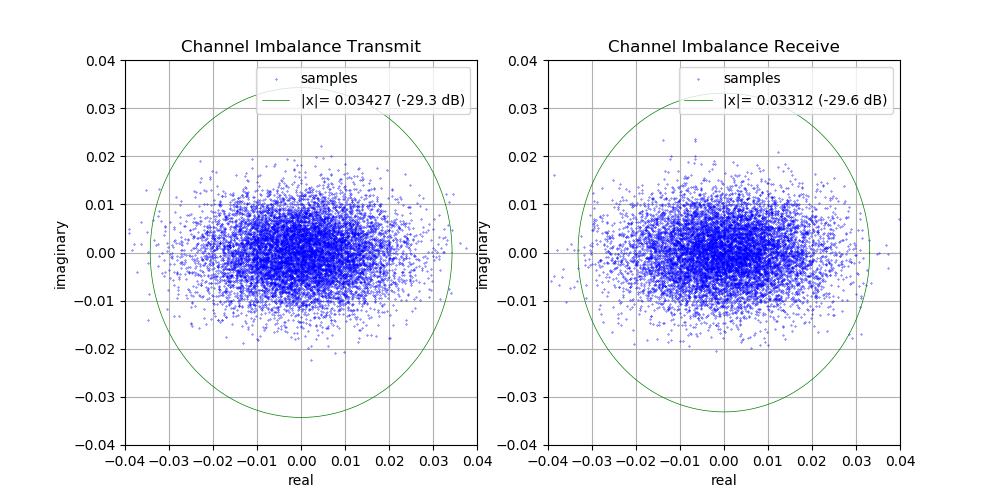

In [463]:
# Number of samples
noCI = 10000

# The CI values assuming T = R
sigma_ci_re = 0.011230     # original value: 0.01230
sigma_ci_im = 0.0060563   # original value: 0.0060563

# the values for CI when T and R are defined individually
sigma_ci_re_t = 0.013882
sigma_ci_im_t = 0.010146
sigma_ci_re_r = 0.012520
sigma_ci_im_r = 0.007637
real_corr     = 0.8 # for ranCI5

# Use one of the defined functions for the CI generation
ci = ranCI(sigma_ci_re, sigma_ci_im, noCI)
# ci = ranCI5(sigma_ci_re_t,sigma_ci_im_t, sigma_ci_re_r, sigma_ci_im_r, real_corr,noCI)

# get the three sigma interval (for the plot)
ci_transmit_sorted = np.sort(np.absolute(ci[0]))
ci_receive_sorted  = np.sort(np.absolute(ci[1]))

threesig_transmit = ci_transmit_sorted[int(0.9973*noCI)-1]
threesig_receive  = ci_receive_sorted[int(0.9973*noCI)-1]

## PLOTTING

# plot real and imaginary distribution of transmit and receive
plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
ax1.set_title("Channel Imbalance Transmit")
ax1.plot(np.real(ci[0]), np.imag(ci[0]), "bo", markersize = 0.3, label = "samples")
ax1.plot(np.cos(np.linspace(0,360,1000)*np.pi/180)*threesig_transmit, np.sin(np.linspace(0,360,1000)*np.pi/180)*threesig_transmit, "g-", linewidth = 0.5, label = "|x|= " + np.str(np.round(threesig_transmit,5)) + " (" +np.str(np.round(20*np.log10(threesig_transmit),2)) + " dB)")
ax1.set_xlim((-0.04,0.04))
ax1.set_ylim((-0.04,0.04))
ax1.set_xlabel("real")
ax1.set_ylabel("imaginary")
plt.grid()
plt.legend()

ax2 = plt.subplot(122)
ax2.set_title("Channel Imbalance Receive")
ax2.plot(np.real(ci[1]), np.imag(ci[1]), "bo", markersize = 0.3, label = "samples")
ax2.plot(np.cos(np.linspace(0,360,1000)*np.pi/180)*threesig_receive, np.sin(np.linspace(0,360,1000)*np.pi/180)*threesig_receive, "g-", linewidth = 0.5, label = "|x|= " + np.str(np.round(threesig_receive,5)) + " (" + np.str(np.round(20*np.log10(threesig_receive),2)) + " dB)")
ax2.set_xlim((-0.04,0.04))
ax2.set_ylim((-0.04,0.04))
ax2.set_xlabel("real")
ax2.set_ylabel("imaginary")
plt.grid()
plt.legend()


## Crosstalk

<IPython.core.display.Javascript object>


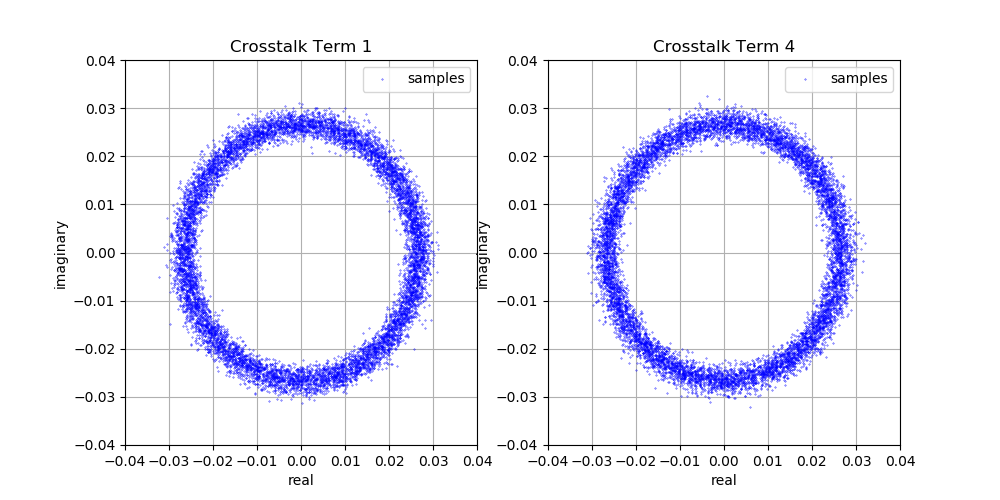

In [464]:
# Number of Samples
noCI = 10000

# mean and std of Crosstalk magnitude (in dB)
mag_xt_dB = -31.5         # original value: -31.5
sigma_xt_dB = 0.5         # original value: 0.5

# covariance between crosstalk terms 1 and 3 and terms 2 and 4
xtCov = 0.5 

# use one of the Crosstalk functions
xt = ranXT2(mag_xt_dB,sigma_xt_dB,xtCov,noCI)

## PLOTTING

# plot crosstalk terms 1 and 4 
plt.figure(figsize = (10,5))
ax1 = plt.subplot(121)
ax1.plot(np.real(xt[0]), np.imag(xt[0]), "bo", markersize = 0.3, label = "samples")
ax1.set_xlim((-0.04,0.04))
ax1.set_ylim((-0.04,0.04))
ax1.set_title("Crosstalk Term 1")
ax1.set_xlabel("real")
ax1.set_ylabel("imaginary")
plt.grid()
plt.legend()

ax2 = plt.subplot(122)
ax2.plot(np.real(xt[3]), np.imag(xt[3]), "bo", markersize = 0.3, label = "samples")
ax2.set_xlim((-0.04,0.04))
ax2.set_ylim((-0.04,0.04))
ax2.set_title("Crosstalk Term 4")
ax2.set_xlabel("real")
ax2.set_ylabel("imaginary")
plt.grid()
plt.legend()

#  Calculate Biomass Error statistics for given input covariance matrix


### Set power law 


As in Schlund paper: gamma0 = a * log10(AGB) + b <br>
or Quegan paper:     AGB = A * gamma0 ** p <br>
a and b can be directly converted to A and p 

In [465]:
# set a and b
a = 4.71 # 4.71 = Lope Heading 2
b = -25.1 # -25.1 Lope Heading 2 

#calculate A and p 
p_pl = 10/a
A_pl = 10**(-b/a)

### Generate a Scene

In [466]:
# Number of Pixels 
noS = 10000
# Covariance Matrix terms: diagonal and HH-VV covariance 
# gamma = normalised corrcoef = magnitude of covariance/sqrt(sigma_hh*sigma_vv)
# theta = phase of covariance
# Also valid for gamma0 input which is required for the power law parameters identified by Schlund 

AGB = 312.4
sigma_hh = -8.59564
sigma_hv = -13.4408
sigma_vv = -9.14858
theta = 87.68554*np.pi/180
gamma = 0.021602

# tolerance in percent of how much the generated "pixels" dataset statistics can diverge from the input cov mx
tol = 2.0

# generate the Scene
S = makeS(tol,noS,sigma_hh,sigma_hv,sigma_vv,theta,gamma)
Sbiomass = powerLaw(np.sum(abs(S[1])**2)/noS,A_pl,p_pl)
print("estimated biomass from generated dataset: " + np.str(np.round(Sbiomass,2)) + " t/ha")

S matrix within tolerance created after 589 iterations
sigma_hh = (-8.6206+0j)
sigma_hv = (-13.356+0j)
sigma_vv = (-9.1628+0j)
angle = 87.2412
gamma = 0.0218
estimated biomass from generated dataset: 311.47 t/ha


### Loop through CIB and xT 

<IPython.core.display.Javascript object>


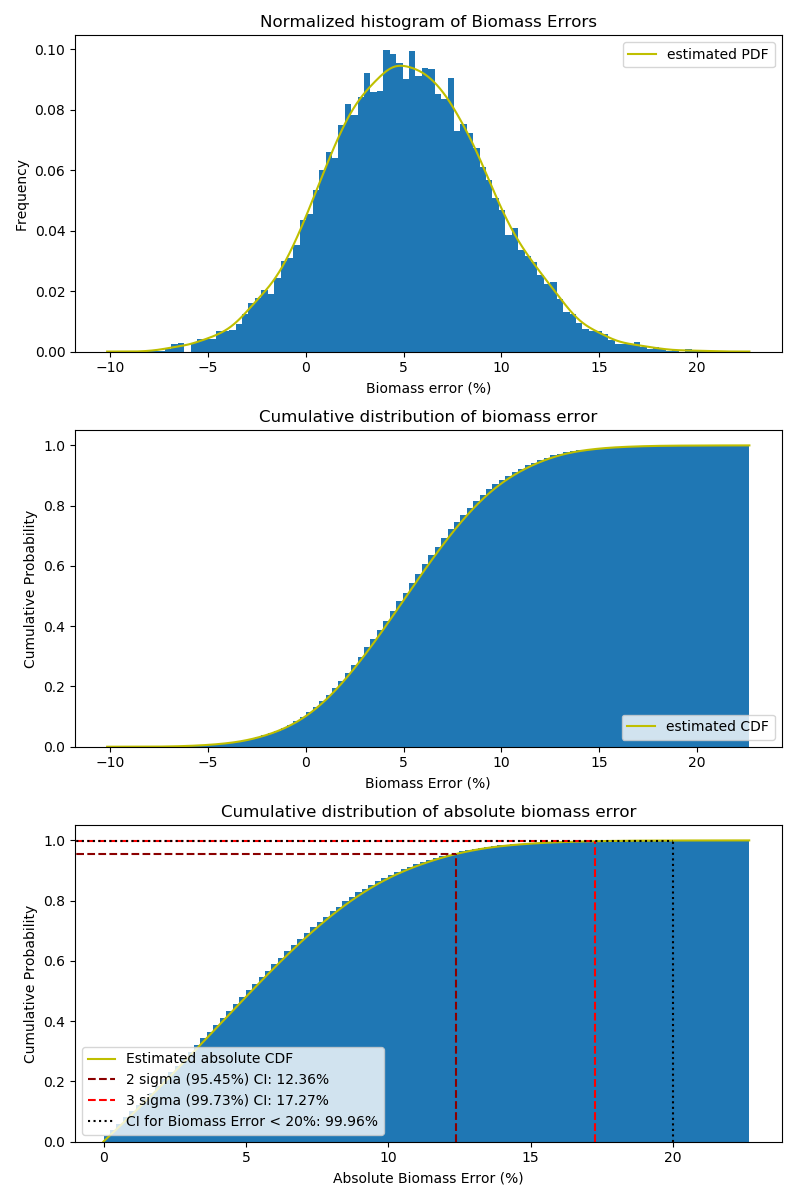

In [467]:
# Set number of samples 
noCI = 10000
# Set Noise as NESZ 
NESZ = -27. # -27.
# Set Biomass Estimation Error threshold to be investigated
PBE = 20

# define CI and xT stats (actually not necessary because defined above, but included for the sake of completeness)
mag_xt_dB = -31.5       # original value: -31.5
sigma_xt_dB = 0.5         # original value: 0.5
xtCov = 0.8              # covariance of xt 1 and 3 and xt 2 and 4

# The CI values if T and R have the same distribution
sigma_ci_re = 0.011230     # original value: 0.011230
sigma_ci_im = 0.0060563   # original value: 0.0060563

# the values for CI when T and R have individual distributions
sigma_ci_re_t = 0.013882
sigma_ci_im_t = 0.010146
sigma_ci_re_r = 0.012520
sigma_ci_im_r = 0.007637
real_corr     = 0.8 # for ranCI5

### END USER INPUT ####

# generate Noise
N = makeN(NESZ,4,noS)
be = np.zeros(noCI)
# here omega is random, but the estimate is fix to 0
# as Mark suggested, it is now fixed outside the loop, since it does not make a big difference
# alternatively: omega = 0
omega = np.random.rand(1)*2*np.pi/180

for i in np.arange(noCI):
    
    
    # again pick a function for xT and CIB
    d = ranXT2(mag_xt_dB, sigma_xt_dB,xtCov,1)
    #f = 1 + ranCI(sigma_ci_re, sigma_ci_im, 1)
    # e.g. alternatively:
    f = 1+ ranCI4(sigma_ci_re_t, sigma_ci_im_t, sigma_ci_re_r, sigma_ci_im_r,1)
    # or with correlation:
    #f = 1 + ranCI5(sigma_ci_re_t,sigma_ci_im_t, sigma_ci_re_r, sigma_ci_im_r, real_corr,1)

    biomass = getBiomass(S,N,f,d,omega, A_pl, p_pl)
    be[i] = 100*(biomass-Sbiomass)/Sbiomass 
    

# KERNEL DENSITY ESTIMATION ######################
# Estimate PDF 
linspace1 = np.linspace(np.min(be), np.max(be), 10000)
kde = stats.gaussian_kde(be)
ys = kde.evaluate(linspace1)

# Get CDF from PDF
ys_cum = np.cumsum(ys)
ys_cum_norm = ys_cum/ys_cum[-1]

# Take PDF and flip over the negative part to get the absolute distribution, and from there the absolute CDF
#if np.min(linspace1) < 0:
if np.min(linspace1) < 0:

    ff = linspace1[linspace1<0]
    gg = np.where(linspace1<0)[0]
    linspace2 = np.linspace(np.min(linspace1)+np.max(abs(ff)),np.max(abs(linspace1)),100000)
    linspace2 = linspace1[np.max(gg):]
    ys_abs = np.copy(ys)
    ys_abs = ys_abs[np.max(gg):]
    ys_abs[gg] = ys_abs[gg] + ys[np.flip(gg)]
    # get CDF
    ys_abs_cum = np.cumsum(ys_abs)
    ys_abs_cum_norm = ys_abs_cum/ys_abs_cum[-1]
    # Get 2 and 3 sigma CIs
    perc_9545 = linspace2[(np.abs(ys_abs_cum_norm-0.9545)).argmin()]
    perc_9973 = linspace2[(np.abs(ys_abs_cum_norm-0.9973)).argmin()] 
else:
    # if linspace1 = abs(linspace1) then ys_cum_norm already is the cdf of the absolute error
    ys_abs_cum_norm = ys_cum_norm
    linspace2 = linspace1
    perc_9545 = linspace2[(np.abs(ys_abs_cum_norm-0.9545)).argmin()]
    perc_9973 = linspace2[(np.abs(ys_abs_cum_norm-0.9973)).argmin()]
'''
# Get 2 and 3 sigma CIs
perc_9545 = linspace2[(np.abs(ys_abs_cum_norm-0.9545)).argmin()]
perc_9973 = linspace2[(np.abs(ys_abs_cum_norm-0.9973)).argmin()]
'''
# Get CI of abs(BE) < 20 
CI20 = ys_abs_cum_norm[(np.abs(linspace2-PBE)).argmin()]
CI20_perc = CI20*100

# PLOTTING ####################################

plt.figure(figsize = (8,12))
ax1 = plt.subplot(311)
ax1.hist(be,100, density = True)
ax1.set_title("Normalized histogram of Biomass Errors")
ax1.set_xlabel("Biomass error (%)")
ax1.set_ylabel("Frequency")
plt.plot(linspace1,ys,"y-", label = "estimated PDF")
plt.legend()

ax2 = plt.subplot(312)
ax2.set_title("Cumulative distribution of biomass error")
n, bins, patches = ax2.hist(be,100,cumulative = True, density = True)
ax2.set_xlabel("Biomass Error (%)")
ax2.set_ylabel("Cumulative Probability")
plt.plot(linspace1, ys_cum_norm, "y-", label = "estimated CDF")
plt.legend(loc = 4)

ax3 = plt.subplot(313)
ax3.set_title("Cumulative distribution of absolute biomass error")
n,bins,patches = ax3.hist(abs(be),100, cumulative = True, density = True)
ax3.plot(linspace2,ys_abs_cum_norm, "y-", label = "Estimated absolute CDF")
plt.xlim(left = -1)
ax3.plot([perc_9545,perc_9545],[0,0.9545],color = "darkred", linestyle = "dashed", label = "2 sigma (95.45%) CI: " + np.str(np.round(perc_9545,2)) + "%")
ax3.plot([-5,perc_9545],[0.9545,0.9545],color = "darkred", linestyle = "dashed")
ax3.plot([perc_9973,perc_9973],[0,0.9973],color = "red", linestyle = "dashed", label = "3 sigma (99.73%) CI: " + np.str(np.round(perc_9973,2)) + "%")
ax3.plot([-5,perc_9973],[0.9973,0.9973],color = "red", linestyle = "dashed")
ax3.plot([PBE,PBE],[0,CI20], color = "black", linestyle = "dotted")
ax3.plot([-5,PBE],[CI20,CI20], color = "black", linestyle = "dotted", label = "CI for Biomass Error < " + np.str(PBE) + "%: " + np.str(np.round(CI20_perc,2)) + "%")
ax3.set_xlabel("Absolute Biomass Error (%)")
ax3.set_ylabel("Cumulative Probability")
plt.legend(loc = 3)
plt.tight_layout()
